<a href="https://colab.research.google.com/github/annienyamekye/Kaggle-challenge/blob/main/Dog_classification_using_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

In [3]:
import tensorflow_datasets as tfds

In [4]:
dataset, info = tfds.load(name="stanford_dogs", with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteEYSPND/stanford_dogs-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteEYSPND/stanford_dogs-test.tfrecord


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [5]:
import matplotlib.pyplot as plt


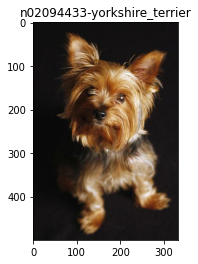

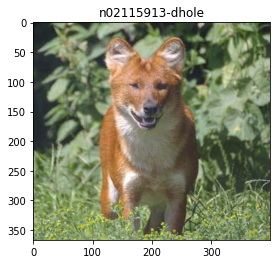

In [6]:
get_name = info.features['label'].int2str

for dog in dataset['train'].take(2):
  plt.figure()
  plt.imshow(dog['image'])
  plt.title(get_name(dog['label']))

In [8]:
image_length = 150
image_height = 150
number_of_breeds = 120
batch_size = 32

image_shape = (150,150,3)

test_data = dataset['test']
train_data = dataset['train']

def preprocess(ds_row):

  image = tf.image.convert_image_dtype(ds_row['image'], dtype=tf.float32)
  image = tf.image.resize(image, (image_length,image_length), method='nearest')

  label = tf.one_hot(ds_row['label'],number_of_breeds)

  return image, label

def prepare(dataset, batch_size=None):
  ds = dataset.map(preprocess, num_parallel_calls=4)
  ds = ds.shuffle(buffer_size=1000)
  if batch_size:
    ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

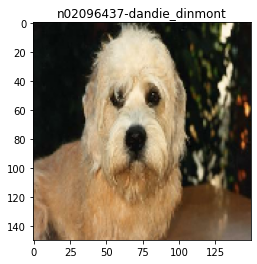

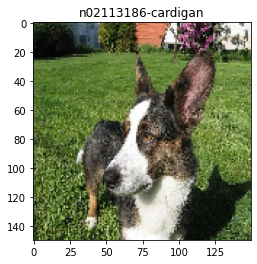

In [9]:
decode = lambda x: get_name(tf.math.argmax(x))

for pic, label in prepare(train_data).take(2):
  plt.figure()
  plt.imshow(pic)
  plt.title(decode(label))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Activation, MaxPooling2D, Dropout, Flatten

In [23]:
model = Sequential()
model.add(Conv2D(32, (3,3),input_shape=(150,150,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(120))
model.add(Activation('softmax'))

In [24]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
activation_17 (Activation)   (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
activation_18 (Activation)   (None, 72, 72, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 34, 34, 64)       

In [25]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [26]:
train_sets = prepare(train_data, batch_size=32)
test_sets = prepare(test_data, batch_size=32)

history = model.fit(train_sets,
                    validation_data=test_sets,epochs=30)

Epoch 1/30
375/375 [==============================] - 352s 930ms/step - loss: 4.8140 - accuracy: 0.0064 - val_loss: 4.7874 - val_accuracy: 0.0079
Epoch 2/30
375/375 [==============================] - 350s 926ms/step - loss: 4.7886 - accuracy: 0.0078 - val_loss: 4.7592 - val_accuracy: 0.0126
Epoch 3/30
375/375 [==============================] - 351s 930ms/step - loss: 4.7381 - accuracy: 0.0137 - val_loss: 4.6363 - val_accuracy: 0.0224
Epoch 4/30
375/375 [==============================] - 351s 931ms/step - loss: 4.6277 - accuracy: 0.0206 - val_loss: 4.5467 - val_accuracy: 0.0298
Epoch 5/30
375/375 [==============================] - 351s 931ms/step - loss: 4.5276 - accuracy: 0.0277 - val_loss: 4.4669 - val_accuracy: 0.0389
Epoch 6/30
375/375 [==============================] - 351s 931ms/step - loss: 4.4098 - accuracy: 0.0380 - val_loss: 4.3888 - val_accuracy: 0.0457
Epoch 7/30
375/375 [==============================] - 353s 934ms/step - loss: 4.2929 - accuracy: 0.0515 - val_loss: 4.3468 -

In [27]:
losses = pd.DataFrame(model.history.history)

In [28]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,4.794788,0.005250,4.787356,0.007925
1,4.785512,0.008500,4.759199,0.012587
2,4.713651,0.017500,4.636289,0.022378
3,4.603188,0.021417,4.546669,0.029837
4,4.502864,0.031000,4.466914,0.038928


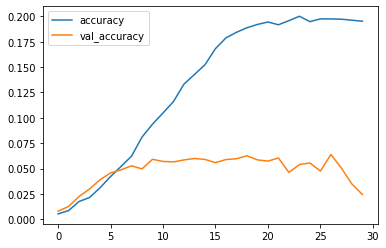

In [29]:
losses[['accuracy','val_accuracy']].plot()

In [30]:
base_model = tf.keras.applications.MobileNetV2(input_shape = image_shape,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [31]:
base_model.trainable = False

model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(number_of_breeds, activation='softmax')
])

In [32]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [34]:
train_sets = prepare(train_data, batch_size=32)
test_sets = prepare(test_data, batch_size=32)

history = model.fit(train_sets,
                    validation_data=test_sets,epochs=30)

Epoch 1/30
375/375 [==============================] - 349s 920ms/step - loss: 3.0124 - accuracy: 0.3145 - val_loss: 1.7789 - val_accuracy: 0.5374
Epoch 2/30
375/375 [==============================] - 346s 919ms/step - loss: 1.3352 - accuracy: 0.6283 - val_loss: 1.7743 - val_accuracy: 0.5704
Epoch 3/30
375/375 [==============================] - 345s 916ms/step - loss: 1.0657 - accuracy: 0.7035 - val_loss: 1.8444 - val_accuracy: 0.5753
Epoch 4/30
375/375 [==============================] - 345s 915ms/step - loss: 0.8859 - accuracy: 0.7459 - val_loss: 1.9921 - val_accuracy: 0.5638
Epoch 5/30
375/375 [==============================] - 346s 916ms/step - loss: 0.7452 - accuracy: 0.7950 - val_loss: 2.0732 - val_accuracy: 0.5659
Epoch 6/30
375/375 [==============================] - 347s 921ms/step - loss: 0.6410 - accuracy: 0.8184 - val_loss: 2.1574 - val_accuracy: 0.5668
Epoch 7/30
375/375 [==============================] - 346s 918ms/step - loss: 0.5486 - accuracy: 0.8498 - val_loss: 2.2620 -

In [35]:
losses = pd.DataFrame(model.history.history)

In [36]:
losses.head()

,loss,accuracy,val_loss,val_accuracy
0,2.264017,0.431583,1.778883,0.537413
1,1.349047,0.631250,1.774261,0.570396
2,1.084882,0.700833,1.844379,0.575291
3,0.902278,0.747833,1.992068,0.563753
4,0.757404,0.792167,2.073200,0.565851


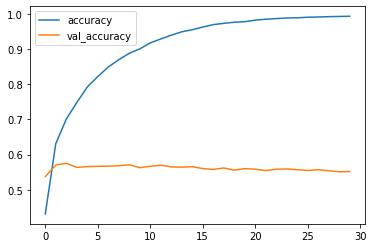

In [37]:
losses[['accuracy','val_accuracy']].plot()

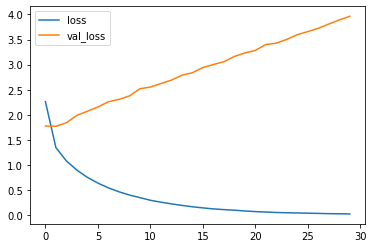

In [38]:
losses[['loss','val_loss']].plot()

In [39]:
model.metrics_names

['loss', 'accuracy']

In [40]:
print(model.metrics_names)
print(model.evaluate(test_sets))

['loss', 'accuracy']
269/269 [==============================] - 145s 531ms/step - loss: 3.9631 - accuracy: 0.5519
[3.9630632400512695, 0.5518648028373718]
